# KPI Anomaly Detection

Group: 
- Zihang WANG
- Liyang FANG

Dataset:
* [KPI Anomaly Detectionn](https://competition.aiops-challenge.com/home/competition/1484452272200032281)

## EDA

### Data Preparation

In [13]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings("ignore")

In [15]:
data_folder = "../data/"

train_file = "train.csv"
test_file = "test.csv"

train_path = data_folder + train_file
test_path = data_folder + test_file

In [16]:
df_train = pd.read_csv(train_path).rename(columns={"KPI ID": "kpi_id"})
df_train["datetime"] = pd.to_datetime(df_train.timestamp, unit="s")

In [17]:
df_test = pd.read_csv(test_path).rename(columns={"KPI ID": "kpi_id"})
df_test["datetime"] = pd.to_datetime(df_test.timestamp, unit="s")

In [18]:
df_train.head()

,timestamp,value,label,kpi_id,datetime
0,1493568000,1.901639,0,02e99bd4f6cfb33f,2017-04-30 16:00:00
1,1493568060,1.786885,0,02e99bd4f6cfb33f,2017-04-30 16:01:00
2,1493568120,2.000000,0,02e99bd4f6cfb33f,2017-04-30 16:02:00
3,1493568180,1.885246,0,02e99bd4f6cfb33f,2017-04-30 16:03:00
4,1493568240,1.819672,0,02e99bd4f6cfb33f,2017-04-30 16:04:00


In [19]:
print(f"Missing values is {df_train.isnull().sum().sum()}")
print(f"Duplicated values is {df_train.duplicated().sum()}")
print(f"Number of unique KPI ID is {df_train.kpi_id.nunique()}")

Missing values is 0
Duplicated values is 0
Number of unique KPI ID is 26


### Anomaly exploration 

In [20]:
print(
    f"Percentage of anomalies is {len(df_train[df_train['label'] == 1]) / len(df_train) * 100:.2f}%"
)

Percentage of anomalies is 2.16%


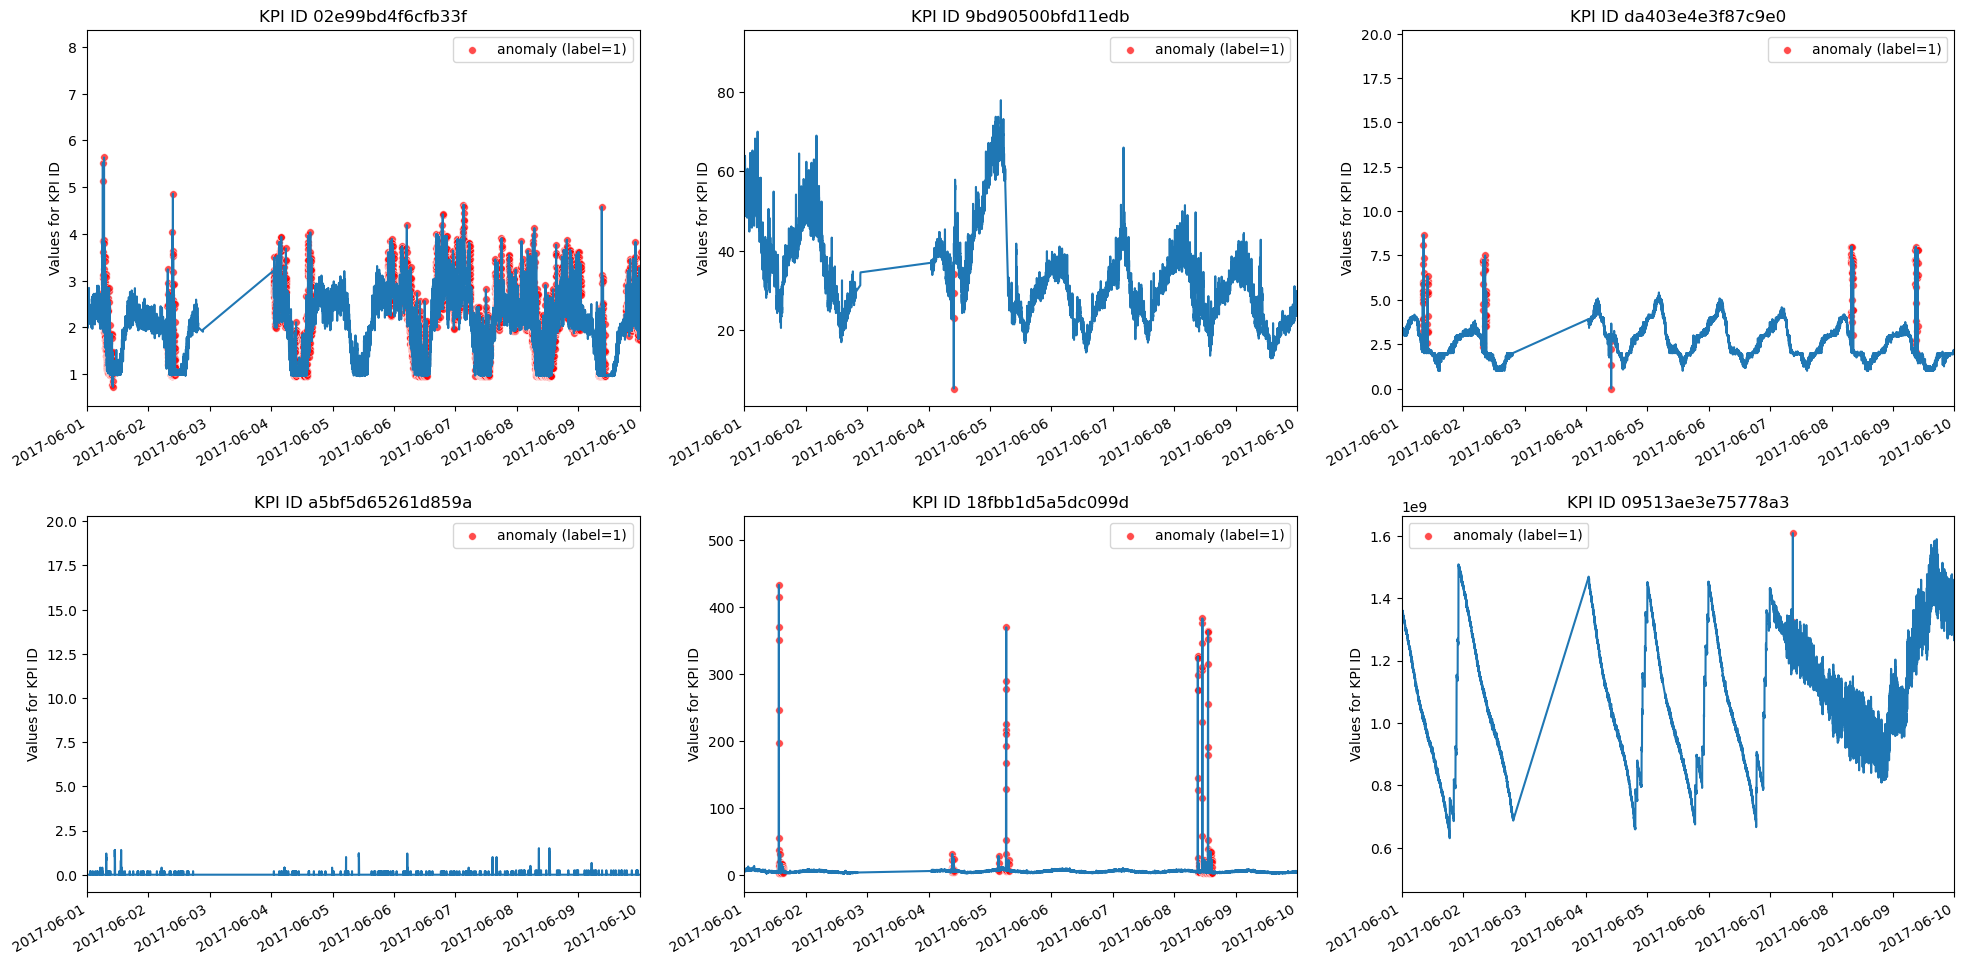

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for kpi_id, ax in zip(df_train.kpi_id.unique()[:6], axs.flatten()):
    data = df_train[df_train.kpi_id == kpi_id]
    sns.lineplot(data=data, x="datetime", y="value", ax=ax)
    sns.scatterplot(
        data=data[data.label == 1],
        x="datetime",
        y="value",
        color="r",
        s=30,
        alpha=0.7,
        label="anomaly (label=1)",
        ax=ax,
    )
    ax.set_xlim(datetime.datetime(2017, 6, 1), datetime.datetime(2017, 6, 10))
    ax.legend()
    ax.title.set_text(f"KPI ID {kpi_id}")
    ax.set_ylabel("Values for KPI ID")
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
plt.tight_layout(pad=2)
plt.show()